## CHURN DATASET ANALYSIS


In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("Churn.csv")
df.head(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


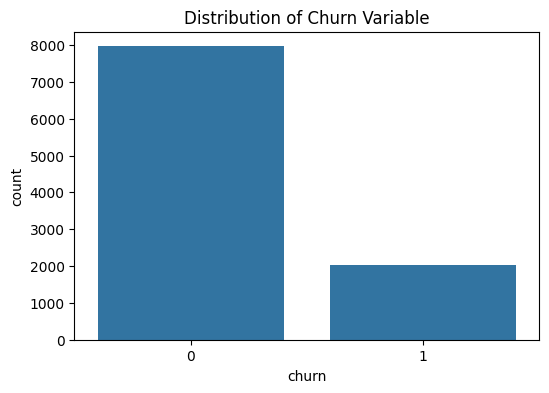

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64


In [17]:
import seaborn as sns

target_column = 'churn'  # Corrected from 'target' to actual column name

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=target_column)
plt.title('Distribution of Churn Variable')
plt.xticks(rotation=0)
plt.show()

# Also print the proportion of each class
print(df[target_column].value_counts(normalize=True))


/home/wycliffe/.local/lib/aims/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:46:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


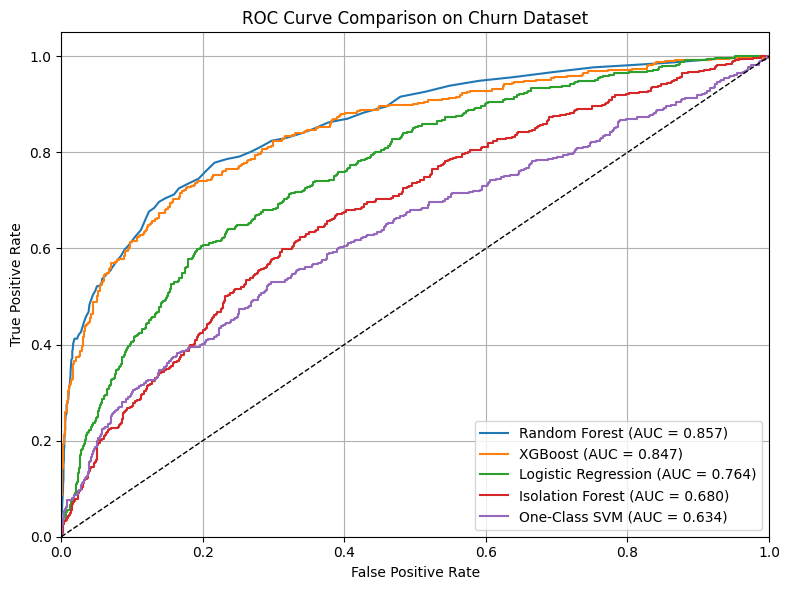

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

# Step 1: Load and clean dataset
df = pd.read_csv("Churn.csv")
df.columns = df.columns.str.strip()  # remove whitespace
df = df.drop(columns=['customer_id'])  # Drop ID column

# Step 2: Encode categorical variables
categorical_cols = ['country', 'gender']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Step 3: Feature-target split
X = df.drop(columns=['churn'])
y = df['churn']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train supervised models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Step 7: Train anomaly detectors (on normal class: churn = 0)
X_train_norm = X_train_scaled[y_train == 0]

iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train_norm)

ocsvm = OneClassSVM(nu=0.5, kernel='rbf', gamma='scale')
ocsvm.fit(X_train_norm)

# Step 8: Get prediction scores
def get_model_scores(name, model, X):
    if name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
        return model.predict_proba(X)[:, 1]
    elif name == 'Isolation Forest':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
    elif name == 'One-Class SVM':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()

# Step 9: Plot ROC curves
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'Logistic Regression': lr,
    'Isolation Forest': iso,
    'One-Class SVM': ocsvm
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    scores = get_model_scores(name, model, X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison on Churn Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("rroc_comparison_churn.png", dpi=300)
plt.show()


/home/wycliffe/.local/lib/aims/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:14:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


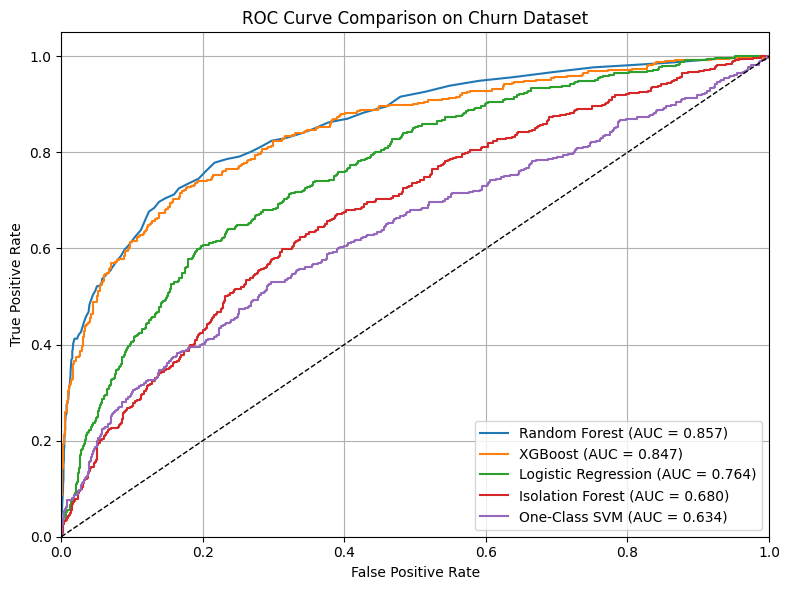

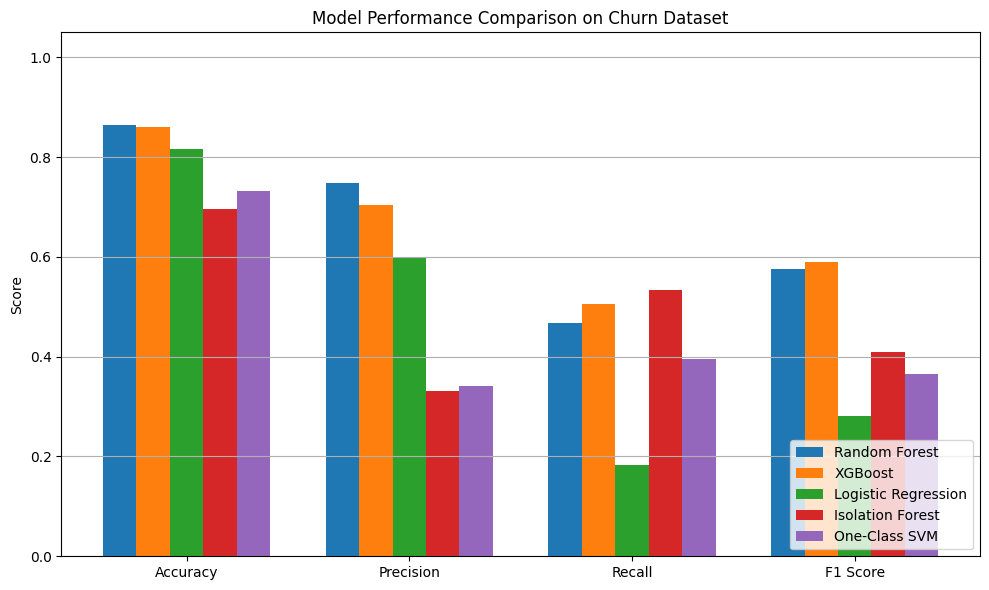

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Step 1: Load and clean dataset
df = pd.read_csv("Churn.csv")
df.columns = df.columns.str.strip()  # remove whitespace
df = df.drop(columns=['customer_id'])  # Drop ID column

# Step 2: Encode categorical variables
categorical_cols = ['country', 'gender']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Step 3: Feature-target split
X = df.drop(columns=['churn'])
y = df['churn']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train supervised models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)

# Step 7: Train anomaly detectors (on normal class: churn = 0)
X_train_norm = X_train_scaled[y_train == 0]

iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train_norm)

ocsvm = OneClassSVM(nu=0.5, kernel='rbf', gamma='scale')
ocsvm.fit(X_train_norm)

# Step 8: Get prediction scores
def get_model_scores(name, model, X):
    if name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
        return model.predict_proba(X)[:, 1]
    elif name == 'Isolation Forest':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
    elif name == 'One-Class SVM':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()

# Dictionary of models for evaluation and plotting
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'Logistic Regression': lr,
    'Isolation Forest': iso,
    'One-Class SVM': ocsvm
}

# Step 9: Plot ROC curves
plt.figure(figsize=(8, 6))

for name, model in models.items():
    scores = get_model_scores(name, model, X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison on Churn Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_comparison_churn.pdf", dpi=300)
plt.show()

# Step 10: Calculate metrics for all models
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score
}

# Store metrics results here
results = {name: {} for name in models.keys()}

for name, model in models.items():
    # Get binary predictions for supervised models
    if name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
        preds = model.predict(X_test_scaled)
    else:
        # For anomaly detectors, threshold scores at 0.5
        scores = get_model_scores(name, model, X_test_scaled)
        preds = [1 if s > 0.5 else 0 for s in scores]

    for metric_name, metric_func in metrics.items():
        if metric_name in ['Precision', 'Recall', 'F1 Score']:
            results[name][metric_name] = metric_func(y_test, preds, zero_division=0)
        else:
            results[name][metric_name] = metric_func(y_test, preds)

# Step 11: Plot metric comparison bar chart
import numpy as np

metric_names = list(metrics.keys())
model_names = list(models.keys())

# Prepare data for plotting
data = np.array([[results[m][metric] for metric in metric_names] for m in model_names])

x = np.arange(len(metric_names))  # metric positions
width = 0.15  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, model_name in enumerate(model_names):
    ax.bar(x + i*width, data[i], width, label=model_name)

ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metric_names)
ax.set_ylim([0, 1.05])
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison on Churn Dataset')
ax.legend(loc='lower right')
ax.grid(axis='y')

plt.tight_layout()
plt.savefig("metric_performance_comparison_churn.pdf", dpi=300)
plt.show()


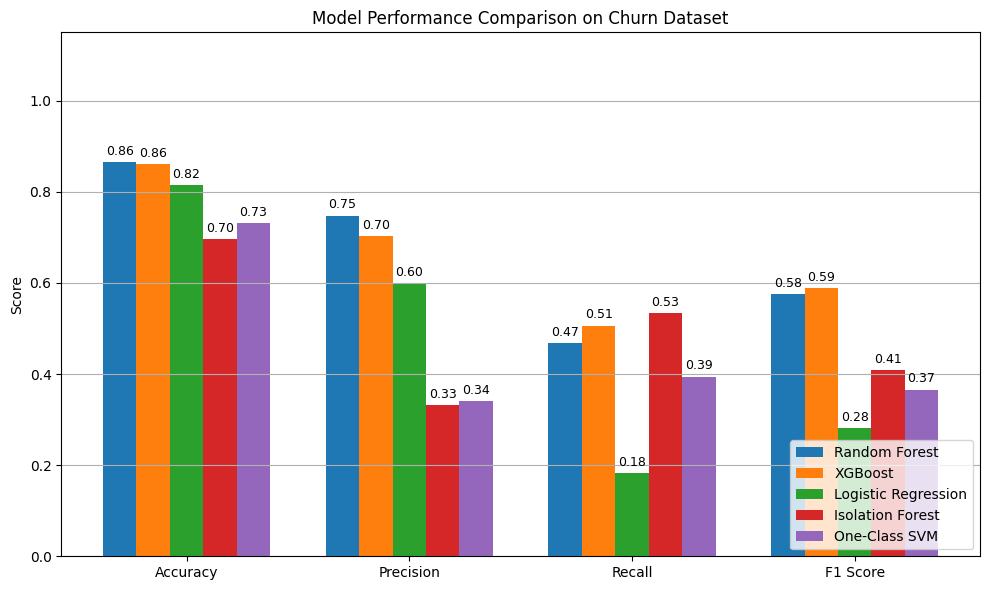

In [2]:
import numpy as np
import matplotlib.pyplot as plt

metric_names = list(metrics.keys())
model_names = list(models.keys())

# Prepare data for plotting
data = np.array([[results[m][metric] for metric in metric_names] for m in model_names])

x = np.arange(len(metric_names))  # metric positions
width = 0.15  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, model_name in enumerate(model_names):
    bars = ax.bar(x + i*width, data[i], width, label=model_name)
    # Add float labels (e.g., 0.63) on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metric_names)
ax.set_ylim([0, 1.15])
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison on Churn Dataset')
ax.legend(loc='lower right')
ax.grid(axis='y')

plt.tight_layout()
plt.savefig("metric_performance_comparison_churn_float.pdf", dpi=300)
plt.show()


In [8]:
df.describe()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.746300,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.827529,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,0.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
from sklearn.metrics import classification_report

# Updated evaluation function with classification report
def evaluate_model_threshold_report(name, model, X_test, y_test, unsupervised=False):
    if unsupervised:
        scores_raw = -model.decision_function(X_test)
        scaler = MinMaxScaler()
        probs = scaler.fit_transform(scores_raw.reshape(-1, 1)).ravel()
    else:
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:, 1]
        else:
            scores = model.decision_function(X_test)
            probs = (scores - scores.min()) / (scores.max() - scores.min())

    thresholds = np.linspace(0, 1, 100)
    f1_scores = []
    for t in thresholds:
        preds = (probs > t).astype(int)
        f1_scores.append(f1_score(y_test, preds))
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    preds = (probs > best_thresh).astype(int)

    print(f"\n{name} Evaluation:")
    print(f" Best Threshold: {best_thresh:.2f}")
    print(classification_report(y_test, preds, digits=4))

# Evaluate supervised models with classification report
evaluate_model_threshold_report("Random Forest", best_rf, X_test, y_test)
evaluate_model_threshold_report("XGBoost", best_xgb, X_test, y_test)
evaluate_model_threshold_report("Logistic Regression", lr, X_test, y_test)

# Evaluate unsupervised models with classification report
evaluate_model_threshold_report("Isolation Forest", iso, X_test, y_test, unsupervised=True)
evaluate_model_threshold_report("One-Class SVM", best_ocsvm, X_test, y_test, unsupervised=True)

# Ensemble classification report
ensemble_preds = ensemble_predict([best_rf, best_xgb, lr], X_test, threshold=0.4)
print("\nEnsemble Evaluation:")
print(classification_report(y_test, ensemble_preds, digits=4))


NameError: name 'best_rf' is not defined

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

# Load and clean
df = pd.read_csv("Churn.csv")
df.columns = df.columns.str.strip()
df.drop(columns=["customer_id"], inplace=True)

# Encode categoricals
df["country"] = LabelEncoder().fit_transform(df["country"])
df["gender"] = LabelEncoder().fit_transform(df["gender"])

X = df.drop(columns=["churn"])
y = df["churn"]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection: 8 features now
rfe_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rfe = RFE(rfe_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X_scaled, y)
selected_columns = X.columns[rfe.support_]
print("Selected Features:", list(selected_columns))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparam tuning RF (same as before)
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}
random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10,
    scoring='f1', cv=3, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
best_rf = random_search_rf.best_estimator_

# Calibrate RF
cal_rf = CalibratedClassifierCV(best_rf, cv=3)
cal_rf.fit(X_train, y_train)

# XGBoost with scale_pos_weight tuned
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)

# Logistic Regression calibrated
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
cal_lr = CalibratedClassifierCV(lr, cv=3)
cal_lr.fit(X_train, y_train)

# Isolation Forest & OCSVM tuned on no churn only
X_train_unsupervised = X_train[y_train == 0]

iso = IsolationForest(contamination=0.15, random_state=42)
iso.fit(X_train_unsupervised)

best_ocsvm = None
best_f1_ocsvm = 0
for nu in [0.1, 0.15, 0.2]:
    for gamma in ['scale', 'auto']:
        ocsvm = OneClassSVM(nu=nu, kernel='rbf', gamma=gamma)
        ocsvm.fit(X_train_unsupervised)

        scores_raw = -ocsvm.decision_function(X_test)
        probs = MinMaxScaler().fit_transform(scores_raw.reshape(-1, 1)).ravel()

        thresholds = np.linspace(0, 1, 100)
        f1_scores = [f1_score(y_test, (probs > t).astype(int)) for t in thresholds]
        max_f1 = max(f1_scores)
        if max_f1 > best_f1_ocsvm:
            best_f1_ocsvm = max_f1
            best_ocsvm = ocsvm
print(f"Best One-Class SVM F1 after tuning: {best_f1_ocsvm:.4f}")

# Stacking Ensemble
estimators = [
    ('rf', cal_rf),
    ('xgb', xgb),
    ('lr', cal_lr)
]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'), cv=5)
stack.fit(X_train, y_train)

# Evaluation function
def evaluate_with_report(name, model, X_test, y_test, unsupervised=False):
    if unsupervised:
        scores_raw = -model.decision_function(X_test)
        probs = MinMaxScaler().fit_transform(scores_raw.reshape(-1, 1)).ravel()
    else:
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:, 1]
        else:
            scores = model.decision_function(X_test)
            probs = (scores - scores.min()) / (scores.max() - scores.min())

    thresholds = np.linspace(0, 1, 100)
    f1_scores = []
    for t in thresholds:
        preds = (probs > t).astype(int)
        f1_scores.append(f1_score(y_test, preds))
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    preds = (probs > best_thresh).astype(int)

    print(f"\n{name} Evaluation:")
    print(f" Best Threshold: {best_thresh:.2f}")
    print(classification_report(y_test, preds, digits=4))

# Run evaluations
evaluate_with_report("Random Forest (Calibrated)", cal_rf, X_test, y_test)
evaluate_with_report("XGBoost", xgb, X_test, y_test)
evaluate_with_report("Logistic Regression (Calibrated)", cal_lr, X_test, y_test)
evaluate_with_report("Isolation Forest", iso, X_test, y_test, unsupervised=True)
evaluate_with_report("One-Class SVM", best_ocsvm, X_test, y_test, unsupervised=True)
evaluate_with_report("Stacking Ensemble", stack, X_test, y_test)


Selected Features: ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'active_member']


/home/wycliffe/.local/lib/aims/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:46:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best One-Class SVM F1 after tuning: 0.3889


/home/wycliffe/.local/lib/aims/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:46:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/wycliffe/.local/lib/aims/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:46:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Random Forest (Calibrated) Evaluation:
 Best Threshold: 0.33
              precision    recall  f1-score   support

           0     0.9077    0.9014    0.9046      1593
           1     0.6244    0.6413    0.6327       407

    accuracy                         0.8485      2000
   macro avg     0.7661    0.7714    0.7686      2000
weighted avg     0.8501    0.8485    0.8492      2000


XGBoost Evaluation:
 Best Threshold: 0.57
              precision    recall  f1-score   support

           0     0.9013    0.8883    0.8947      1593
           1     0.5860    0.6192    0.6022       407

    accuracy                         0.8335      2000
   macro avg     0.7437    0.7537    0.7484      2000
weighted avg     0.8371    0.8335    0.8352      2000


Logistic Regression (Calibrated) Evaluation:
 Best Threshold: 0.23
              precision    recall  f1-score   support

           0     0.8953    0.7677    0.8266      1593
           1     0.4164    0.6486    0.5072       407

    accur